In [47]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder


In [3]:
train_df = pd.read_csv("./train_2016_v2.csv")
train_df.shape

(90275, 3)

In [4]:
train_df.head(n=10)

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02
5,11509835,-0.2705,2016-01-02
6,12286022,0.0440,2016-01-02
7,17177301,0.1638,2016-01-02
8,14739064,-0.0030,2016-01-02
9,14677559,0.0843,2016-01-03


In [5]:
prop= pd.read_csv("./properties_2016.csv",low_memory=False) 
prop.shape

(2985217, 58)

In [6]:
#print (train_df['logerror'].min())
#print (train_df['logerror'].max())


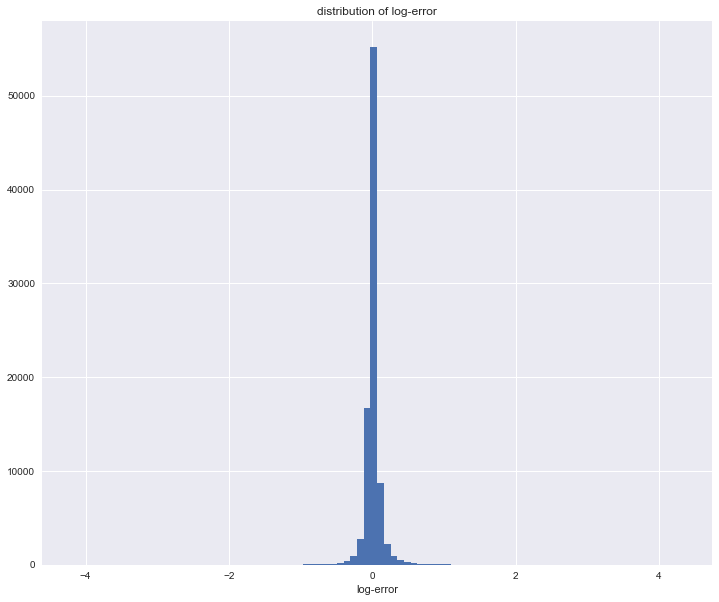

In [7]:
#Histogram of log-errors
plt.figure(figsize=(12,10))
plt.hist(train_df['logerror'], bins= 100)
plt.xlim((train_df['logerror'].min(),train_df['logerror'].max()))
plt.title('distribution of log-error')
plt.xlabel('log-error')
plt.show()
# Below histograms suggests that the distribution of log-errors is close to a normal distributions, 
#it also shows the data has outliers

In [8]:
#Transaction data shows how many times each parcel were sold. 
#size() includes NaN values.
transaction = pd.DataFrame({'count' : train_df.groupby("parcelid").size()}).reset_index()



In [50]:
print ("The percentage of properties sold once is "
        + str(transaction[transaction['count']==1].size / transaction.size * 100) + "%" )
print ("The percentage of properties sold twice is "
        + str(transaction[transaction['count']==2].size / transaction.size * 100) + "%" )
print ("The percentage of properties sold more twice is "
        + str(transaction[transaction['count']>2].size / transaction.size * 100) + "%" )


The percentage of properties sold once is 99.8624514698%
The percentage of properties sold twice is 0.136439267887%
The percentage of properties sold more twice is 0.00110926234054%


In [14]:
(train_df['parcelid'].value_counts().reset_index())['parcelid'].value_counts()

1    90026
2      123
3        1
Name: parcelid, dtype: int64

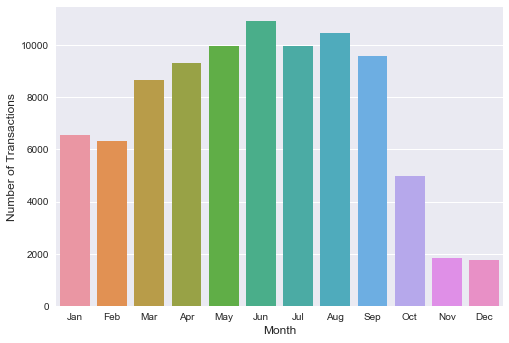

In [15]:
train_df['transactiondate'] = pd.to_datetime(train_df['transactiondate'])
train_df['transactionMonth'] = train_df['transactiondate'].dt.strftime('%b')
transaction_month = train_df['transactionMonth'].value_counts()
sns.barplot(transaction_month.index, transaction_month.values, order=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug',
                                              'Sep','Oct','Nov','Dec'])
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.show()
###There are more transactions during summer months, between May and October. Beginning from October till the end of year,
##the number of transactions drops significantly compared to the previous months. However, the reason for that drop in the graph is
##the dataset contains all transactions before October 15th 2016 and some transactions after that date. 

In [16]:
##Properties data set looks having too many missing values. Let's investigate which variables have the highest missing values.
#nans_df = prop.drop('parcelid', axis=1).isnull().sum()
nans_df = prop.isnull().sum()
nans_df.sort_values(ascending=True, inplace=True)
nans_df = nans_df / prop.shape[0]
#nans_df.sort_values(ascending = False).head(n=15)
nans_df[nans_df>0.8].sort_values(ascending = False)
##There are many variables with large missing value percentage

storytypeid                 0.999456
basementsqft                0.999455
yardbuildingsqft26          0.999113
fireplaceflag               0.998270
architecturalstyletypeid    0.997970
typeconstructiontypeid      0.997740
finishedsquarefeet13        0.997430
buildingclasstypeid         0.995769
decktypeid                  0.994273
finishedsquarefeet6         0.992630
poolsizesum                 0.990634
pooltypeid2                 0.989255
pooltypeid10                0.987626
taxdelinquencyflag          0.981086
taxdelinquencyyear          0.981085
hashottuborspa              0.976881
yardbuildingsqft17          0.973082
finishedsquarefeet15        0.936086
finishedsquarefeet50        0.932093
finishedfloor1squarefeet    0.932093
threequarterbathnbr         0.895609
fireplacecnt                0.895272
pooltypeid7                 0.837379
poolcnt                     0.826634
dtype: float64

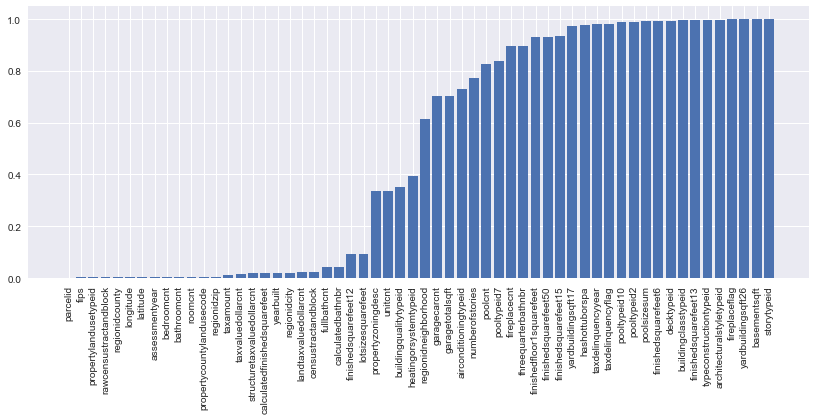

In [17]:
plt.figure(figsize=(14, 5))
plt.bar(range(len(nans_df.index)), nans_df.values)
plt.xticks(range(len(nans_df.index)), nans_df.index.values, rotation='vertical')
plt.show()

In [18]:
##Variables which have too many missing values (>80%) are dropped since they will not provide much information for the analysis. 
zillow= prop.drop(['storytypeid', 'basementsqft', 'yardbuildingsqft26', 'fireplaceflag', 'architecturalstyletypeid', 
            'typeconstructiontypeid', 'finishedsquarefeet13', 'buildingclasstypeid',
            'decktypeid', 'finishedsquarefeet6', 'poolsizesum', 'pooltypeid2', 'pooltypeid10', 'taxdelinquencyflag',
            'taxdelinquencyyear', 'hashottuborspa', 'yardbuildingsqft17', 'finishedsquarefeet15', 'finishedsquarefeet50',
            'finishedfloor1squarefeet', 'threequarterbathnbr', 'fireplacecnt', 'pooltypeid7', 'poolcnt'], axis=1)

In [19]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Data columns (total 34 columns):
parcelid                        int64
airconditioningtypeid           float64
bathroomcnt                     float64
bedroomcnt                      float64
buildingqualitytypeid           float64
calculatedbathnbr               float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
fips                            float64
fullbathcnt                     float64
garagecarcnt                    float64
garagetotalsqft                 float64
heatingorsystemtypeid           float64
latitude                        float64
longitude                       float64
lotsizesquarefeet               float64
propertycountylandusecode       object
propertylandusetypeid           float64
propertyzoningdesc              object
rawcensustractandblock          float64
regionidcity                    float64
regionidcounty                  float64
regionidnei

In [20]:
train = pd.merge(train_df, zillow, on='parcelid', how='left')
train.head()

,parcelid,logerror,transactiondate,transactionMonth,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,...,roomcnt,unitcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
0,11016594,0.0276,2016-01-01,Jan,1.0,2.0,3.0,4.0,2.0,1684.0,...,0.0,1.0,1959.0,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,6.037107e+13
1,14366692,-0.1684,2016-01-01,Jan,NaN,3.5,4.0,NaN,3.5,2263.0,...,0.0,NaN,2014.0,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN
2,12098116,-0.0040,2016-01-01,Jan,1.0,3.0,2.0,4.0,3.0,2217.0,...,0.0,1.0,1940.0,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,6.037464e+13
3,12643413,0.0218,2016-01-02,Jan,1.0,2.0,2.0,4.0,2.0,839.0,...,0.0,1.0,1987.0,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,6.037296e+13
4,14432541,-0.0050,2016-01-02,Jan,NaN,2.5,4.0,NaN,2.5,2283.0,...,8.0,NaN,1981.0,2.0,169574.0,434551.0,2015.0,264977.0,5488.96,6.059042e+13


In [21]:
##It looks like there are repetations in features, eg. bathroomcnt and calculatedbathnbr are the same. 
(train['bathroomcnt']-train['calculatedbathnbr']).sum()

0.0

In [22]:
train= train.drop('calculatedbathnbr',axis =1)

In [23]:
(train[['rawcensustractandblock','censustractandblock']]).head()

,rawcensustractandblock,censustractandblock
0,6.037107e+07,6.037107e+13
1,6.059052e+07,NaN
2,6.037464e+07,6.037464e+13
3,6.037296e+07,6.037296e+13
4,6.059042e+07,6.059042e+13


In [24]:
train['rawcensustractandblock'].isnull().sum()

0

In [25]:
##In the data dictionary, the definition of 'rawcensustractandblock' and 'censustractandblock' are the same,eg.census tract and
##block ID combined. So, I drop one of them. 
train = train.drop('censustractandblock',axis = 1)

In [26]:
train = train.drop(['propertyzoningdesc', 'propertycountylandusecode'], axis =1)#object features(like id)

In [27]:
for l in train[['transactionMonth']]:
                #,'propertycountylandusecode', 'propertyzoningdesc']]:
    label = LabelEncoder()
    label.fit(list(train[l].values))
    train[l] = label.transform(list(train[l].values))

In [97]:
##Skip this cell for a while
#X_train = train.drop(['parcelid', 'logerror', 'transactiondate'], axis=1).as_matrix()
#y_train = train['logerror'].values
#names = train.drop(['parcelid', 'logerror', 'transactiondate'], axis=1).columns

In [28]:
#Since Random Forest Regressor does not handle nan's and its performance gets worse when adding 
#features with increasing percentages of nan's. One of the suggested solution is
#replace nan's with a single "clearly out-of-range" value (like -1.0). 
#This enables the tree to split on the criteria "known values vs unknown values"
train_nan = train
for x in train_nan.columns:
    train_nan[x] = train_nan[x].fillna(-1)

X_train = train_nan.drop(['parcelid', 'logerror', 'transactiondate'], axis=1).as_matrix()
y_train = train_nan['logerror'].values
names = train.drop(['parcelid', 'logerror', 'transactiondate'], axis=1).columns

In [26]:
#X_train.dtypes

In [29]:
#random forest
rf1 = RandomForestRegressor(n_estimators=30, max_features=None)

In [30]:
rf1.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=None, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [31]:
##Mean decrease impurity
##Gini impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled 
#if it was randomly labeled according to the distribution of labels in the subset.
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), rf1.feature_importances_), names), 
             reverse=True) )

Features sorted by their score:
[(0.091899999999999996, 'structuretaxvaluedollarcnt'), (0.089499999999999996, 'longitude'), (0.088599999999999998, 'latitude'), (0.079200000000000007, 'taxamount'), (0.077600000000000002, 'lotsizesquarefeet'), (0.072800000000000004, 'landtaxvaluedollarcnt'), (0.067900000000000002, 'taxvaluedollarcnt'), (0.057200000000000001, 'calculatedfinishedsquarefeet'), (0.0557, 'yearbuilt'), (0.045999999999999999, 'finishedsquarefeet12'), (0.043200000000000002, 'regionidzip'), (0.041799999999999997, 'rawcensustractandblock'), (0.0349, 'transactionMonth'), (0.0246, 'regionidcity'), (0.023699999999999999, 'regionidneighborhood'), (0.017600000000000001, 'bedroomcnt'), (0.012699999999999999, 'garagetotalsqft'), (0.012699999999999999, 'bathroomcnt'), (0.0094000000000000004, 'fullbathcnt'), (0.0091000000000000004, 'propertylandusetypeid'), (0.0088000000000000005, 'buildingqualitytypeid'), (0.0083999999999999995, 'heatingorsystemtypeid'), (0.0074999999999999997, 'aircondit

In [32]:
#random forest
rf2 = RandomForestRegressor(n_estimators=50, max_features=None)

In [33]:
rf2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=None, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [34]:
##Mean decrease impurity
##Gini impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled 
#if it was randomly labeled according to the distribution of labels in the subset.
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), rf2.feature_importances_), names), 
             reverse=True) )

Features sorted by their score:
[(0.087400000000000005, 'latitude'), (0.087099999999999997, 'structuretaxvaluedollarcnt'), (0.085500000000000007, 'longitude'), (0.085099999999999995, 'taxamount'), (0.079100000000000004, 'lotsizesquarefeet'), (0.071099999999999997, 'landtaxvaluedollarcnt'), (0.067299999999999999, 'taxvaluedollarcnt'), (0.057799999999999997, 'calculatedfinishedsquarefeet'), (0.054899999999999997, 'yearbuilt'), (0.046899999999999997, 'finishedsquarefeet12'), (0.043499999999999997, 'regionidzip'), (0.040899999999999999, 'rawcensustractandblock'), (0.039300000000000002, 'transactionMonth'), (0.0253, 'regionidneighborhood'), (0.0247, 'regionidcity'), (0.0195, 'bedroomcnt'), (0.012200000000000001, 'garagetotalsqft'), (0.0117, 'bathroomcnt'), (0.01, 'propertylandusetypeid'), (0.0086, 'fullbathcnt'), (0.0080999999999999996, 'heatingorsystemtypeid'), (0.0080000000000000002, 'buildingqualitytypeid'), (0.0079000000000000008, 'airconditioningtypeid'), (0.0061999999999999998, 'roomc

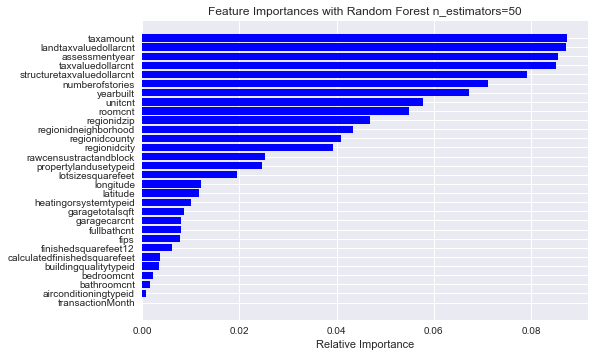

In [35]:
importances2 = rf2.feature_importances_
indices2 = np.argsort(importances2)

plt.title('Feature Importances with Random Forest n_estimators=50')
plt.barh(range(len(indices2)), importances2[indices2], color='b', align='center')
plt.yticks(range(len(indices2)), names) 
plt.xlabel('Relative Importance')
plt.show()

In [36]:
#Imputer
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='median', axis=0)
X_imp = imp.fit_transform(train.drop(['parcelid', 'logerror', 'transactiondate'], axis=1).as_matrix())

In [37]:
#random forest
rf3 = RandomForestRegressor(n_estimators=50, max_features=None)

In [38]:
rf3.fit(X_imp, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=None, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [39]:
##Mean decrease impurity
##Gini impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled 
#if it was randomly labeled according to the distribution of labels in the subset.
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), rf3.feature_importances_), names), 
             reverse=True) )

Features sorted by their score:
[(0.089800000000000005, 'latitude'), (0.086900000000000005, 'structuretaxvaluedollarcnt'), (0.086900000000000005, 'longitude'), (0.084500000000000006, 'taxamount'), (0.081600000000000006, 'lotsizesquarefeet'), (0.070199999999999999, 'landtaxvaluedollarcnt'), (0.069699999999999998, 'taxvaluedollarcnt'), (0.0579, 'calculatedfinishedsquarefeet'), (0.055800000000000002, 'yearbuilt'), (0.0465, 'finishedsquarefeet12'), (0.042900000000000001, 'regionidzip'), (0.040000000000000001, 'rawcensustractandblock'), (0.037400000000000003, 'transactionMonth'), (0.024500000000000001, 'regionidneighborhood'), (0.023900000000000001, 'regionidcity'), (0.018100000000000002, 'bedroomcnt'), (0.012699999999999999, 'garagetotalsqft'), (0.0117, 'bathroomcnt'), (0.0095999999999999992, 'fullbathcnt'), (0.0086999999999999994, 'propertylandusetypeid'), (0.0080999999999999996, 'buildingqualitytypeid'), (0.0079000000000000008, 'heatingorsystemtypeid'), (0.0074000000000000003, 'aircondit

In [40]:
rf3.feature_importances_

array([ 0.03741589,  0.00738642,  0.01166075,  0.01811576,  0.00807302,
        0.05791808,  0.04654692,  0.00085047,  0.00956677,  0.00273832,
        0.01272957,  0.00788817,  0.08980717,  0.08685678,  0.08156746,
        0.0086706 ,  0.03998537,  0.02388383,  0.0011849 ,  0.02448952,
        0.04289896,  0.00580617,  0.0034505 ,  0.05577718,  0.00351939,
        0.0869165 ,  0.06968548,  0.        ,  0.07015567,  0.0844544 ])

In [48]:
#importances = rf3.feature_importances_
#indices = np.argsort(importances)

#plt.title('Feature Importances with Median Imputer')
#plt.barh(range(len(indices)), importances[indices], color='b', align='center')
#plt.yticks(range(len(indices)), names) 
#plt.xlabel('Relative Importance')
#plt.show()

In [42]:
list = pd.DataFrame(
    {'Feature_Name': names,
     'Importance1': rf1.feature_importances_,
     'Importance2': rf2.feature_importances_,
     'Importance3': rf3.feature_importances_
    })
list



,Feature_Name,Importance1,Importance2,Importance3
0,transactionMonth,0.034863,0.039273,0.037416
1,airconditioningtypeid,0.007466,0.007892,0.007386
2,bathroomcnt,0.012678,0.011670,0.011661
3,bedroomcnt,0.017625,0.019533,0.018116
4,buildingqualitytypeid,0.008768,0.008047,0.008073
5,calculatedfinishedsquarefeet,0.057163,0.057805,0.057918
6,finishedsquarefeet12,0.046004,0.046906,0.046547
7,fips,0.001235,0.000918,0.000850
8,fullbathcnt,0.009424,0.008599,0.009567
9,garagecarcnt,0.002219,0.002345,0.002738


In [43]:
list.sort_values(by=['Importance1', 'Importance2','Importance3'], ascending=[False, False,False])

,Feature_Name,Importance1,Importance2,Importance3
25,structuretaxvaluedollarcnt,0.091907,0.087095,0.086916
13,longitude,0.089549,0.085481,0.086857
12,latitude,0.088636,0.087380,0.089807
29,taxamount,0.079193,0.085111,0.084454
14,lotsizesquarefeet,0.077618,0.079115,0.081567
28,landtaxvaluedollarcnt,0.072793,0.071059,0.070156
26,taxvaluedollarcnt,0.067917,0.067311,0.069685
5,calculatedfinishedsquarefeet,0.057163,0.057805,0.057918
23,yearbuilt,0.055712,0.054938,0.055777
6,finishedsquarefeet12,0.046004,0.046906,0.046547


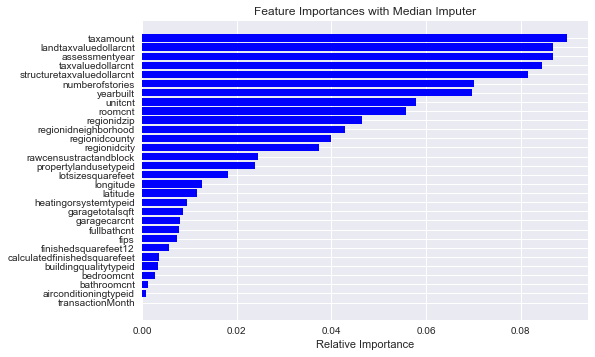

In [44]:
#l3=list.sort_values(by=['Importance3'], ascending=[True])
plt.title('Feature Importances with Median Imputer')
plt.barh(range(len(list['Feature_Name'])), list.sort_values(by=['Importance3'], ascending=[True])['Importance3'], 
         color='b', align='center')
plt.yticks(range(len(list['Feature_Name'])), names) 
plt.xlabel('Relative Importance')
plt.show()


In [45]:
def check(s):
  num = ''
  for letter in s:
    if letter in '.-0123456789':
      num += letter
  if num == '':
    print ('Bad input')
  else:
    return float(num)

In [46]:
check(train)

Bad input
